In [1]:
import os
import pandas as pd
import requests
import time
import json
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns 

from pygam import LinearGAM, s
from sklearn.metrics import mean_squared_error

In [2]:
# --- CONFIG ---
API_KEY = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
os.makedirs(data_folder, exist_ok=True)
tickers_csv_file = os.path.join(data_folder, "sp500_tickers.csv")

# --- LOAD FROM CACHE OR FETCH ---
if os.path.exists(tickers_csv_file):
    print("Loading tickers from CSV cache...")
    df_sp500 = pd.read_csv(tickers_csv_file)
else:
    print("Fetching tickers from API...")
    url = f"https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={API_KEY}"
    df_sp500 = pd.DataFrame(requests.get(url).json())

    # Save to CSV
    df_sp500.to_csv(tickers_csv_file, index=False)
    print(f"Saved {len(df_sp500)} tickers to CSV cache.")

# --- PREVIEW ---
print(df_sp500.shape)
print(df_sp500.columns)

df_sp500.head(2)

tickers = df_sp500["symbol"].dropna().unique().tolist()

Loading tickers from CSV cache...
(503, 8)
Index(['symbol', 'name', 'sector', 'subSector', 'headQuarter',
       'dateFirstAdded', 'cik', 'founded'],
      dtype='object')


In [3]:
# Set up data folder and file paths
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
csv_file = os.path.join(data_folder, "sp500_tickers.csv")
json_file = os.path.join(data_folder, "income_statements.json")

# Define which fields to keep
desired_fields = [
    'symbol',
    'date',
    'revenue',
    'grossProfit',
    'operatingIncome',
    'netIncome',
    'eps',
    'ebitda',
    'costOfRevenue',
    'operatingExpenses'
]

# Try loading from cached JSON if it exists
if os.path.exists(json_file):
    print("Loading data from JSON cache...")
    with open(json_file, 'r') as f:
        records = json.load(f)
else:
    # Load tickers
    df = pd.read_csv(csv_file)
    tickers = df_sp500['symbol'].dropna().tolist()

    API_KEY = 'YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6'
    records = []

    # Fetch most recent income statement per ticker
    for ticker in tickers:
        url = f'https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=1&apikey={API_KEY}'
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            if data:
                row = data[0]
                row['symbol'] = ticker
                filtered_row = {k: row.get(k, None) for k in desired_fields}
                records.append(filtered_row)
        except requests.exceptions.RequestException as e:
            print(f"Error fetching {ticker}: {e}")
        time.sleep(.2)  # Rate limiting

    # Save to JSON
    with open(json_file, 'w') as f:
        json.dump(records, f, indent=2)
    print("Saved data to JSON cache.")

# Convert to DataFrame
income_df = pd.DataFrame(records)

# Show sample
print(income_df.shape)
print(income_df.columns)
income_df.head(2)

Loading data from JSON cache...
(503, 10)
Index(['symbol', 'date', 'revenue', 'grossProfit', 'operatingIncome',
       'netIncome', 'eps', 'ebitda', 'costOfRevenue', 'operatingExpenses'],
      dtype='object')


,symbol,date,revenue,grossProfit,operatingIncome,netIncome,eps,ebitda,costOfRevenue,operatingExpenses
0,XYZ,2024-12-31,24121053000,8734327000,2038013000,2897047000,4.7,1742583000,15386726000,6696314000
1,TTD,2024-12-31,2444831000,1972819000,427167000,393076000,0.8,514657000,472012000,1545652000


In [4]:
def fetch_statement(endpoint, tickers, period, limit, data_folder):
    """Fetch statements with unique JSON filename based on endpoint, period, limit."""
    output_file = os.path.join(
        data_folder,
        f"{endpoint}_{period}_limit{limit}.json"
    )

    if os.path.exists(output_file):
        print(f"Loading from cache: {output_file}")
        with open(output_file, "r") as f:
            return json.load(f)

    records = []
    for ticker in tickers:
        url = f"https://financialmodelingprep.com/api/v3/{endpoint}/{ticker}?period={period}&limit={limit}&apikey={API_KEY}"
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            if data:
                for row in data:
                    row["symbol"] = ticker
                records.extend(data)
        except Exception as e:
            print(f"Error fetching {ticker} ({endpoint}): {e}")
        time.sleep(.2)  # API polite rate limit

    with open(output_file, "w") as f:
        json.dump(records, f, indent=2)
    print(f"Saved {len(records)} records to {output_file}")
    return records


income_data_yoy   = fetch_statement("income-statement", tickers, "annual", 2, data_folder)
balance_data_yoy  = fetch_statement("balance-sheet-statement", tickers, "annual", 2, data_folder)
cashflow_data_yoy = fetch_statement("cash-flow-statement", tickers, "annual", 2, data_folder)

# Convert to DataFrames
income_data_yoy   = pd.DataFrame(income_data_yoy)
balance_data_yoy  = pd.DataFrame(balance_data_yoy)
cashflow_data_yoy = pd.DataFrame(cashflow_data_yoy)

print("Income shape:", income_data_yoy.shape)
print("Balance shape:", balance_data_yoy.shape)
print("Cash flow shape:", cashflow_data_yoy.shape)

print(income_data_yoy.columns)
print(balance_data_yoy.columns)
print(cashflow_data_yoy.columns)

Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/income-statement_annual_limit2.json
Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/balance-sheet-statement_annual_limit2.json
Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/cash-flow-statement_annual_limit2.json
Income shape: (1006, 38)
Balance shape: (1006, 54)
Cash flow shape: (1006, 40)
Index(['date', 'symbol', 'reportedCurrency', 'cik', 'fillingDate',
       'acceptedDate', 'calendarYear', 'period', 'revenue', 'costOfRevenue',
       'grossProfit', 'grossProfitRatio', 'researchAndDevelopmentExpenses',
       'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses',
       'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
       'operatingExpenses', 'costAndExpenses', 'interestIncome',
       'interestExpense', 'depreciationAndAmortization', 'ebitda',
       'ebitdaratio', 'operatingIncome', 'operatingIncomeRatio',
       'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
  

In [5]:
# Ensure DataFrame is sorted
income_data_yoy = income_data_yoy.sort_values(['symbol', 'calendarYear'])

# Define the metrics you want YoY growth for
metrics_to_grow = ['revenue', 'grossProfit', 'operatingIncome', 'netIncome', 'epsdiluted', 'ebitda']

# Loop through metrics and create YoY growth columns
for metric in metrics_to_grow:
    if metric in income_data_yoy.columns:
        income_data_yoy[f'{metric}_yoy'] = income_data_yoy.groupby('symbol')[metric].pct_change()

# Check the results
print(income_data_yoy.head(20))


           date symbol reportedCurrency         cik fillingDate  \
649  2023-10-31      A              USD  0001090872  2023-12-20   
648  2024-10-31      A              USD  0001090872  2024-12-20   
823  2023-09-30   AAPL              USD  0000320193  2023-11-03   
822  2024-09-28   AAPL              USD  0000320193  2024-11-01   
391  2023-12-31   ABBV              USD  0001551152  2024-02-20   
390  2024-12-31   ABBV              USD  0001551152  2025-02-14   
61   2023-12-31   ABNB              USD  0001559720  2024-02-16   
60   2024-12-31   ABNB              USD  0001559720  2025-02-13   
901  2023-12-31    ABT              USD  0000001800  2024-02-16   
900  2024-12-31    ABT              USD  0000001800  2025-02-21   
83   2023-12-31   ACGL              USD  0000947484  2024-02-23   
82   2024-12-31   ACGL              USD  0000947484  2025-02-27   
427  2023-08-31    ACN              USD  0001467373  2023-10-12   
426  2024-08-31    ACN              USD  0001467373  2024-10-1

In [6]:
# List of growth columns (adjust if you add more)
growth_cols = [col for col in income_data_yoy.columns if col.endswith('_yoy')]

# Make a copy of the DataFrame
income_growth_clean = income_data_yoy.copy()

# Drop rows where any of the growth columns are NaN
income_growth_clean = income_growth_clean.dropna(subset=growth_cols)

print("Original shape:", income_data_yoy.shape)
print("Cleaned shape:", income_growth_clean.shape)

# Now income_growth_clean has only rows where growth can be computed


Original shape: (1006, 44)
Cleaned shape: (502, 44)


In [7]:
# 1. Set up paths
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
csv_file    = os.path.join(data_folder, "sp500_tickers.csv")
json_file   = os.path.join(data_folder, "company_info.json")

# 2. Define the fields you want to keep
desired_fields = [
    "symbol", "companyName", "marketCap", "sector", "industry", "beta",
    "price", "lastAnnualDividend", "volume", "exchange", "exchangeShortName",
    "country", "isEtf", "isFund"
]

# 3. Load or fetch company info
records = []

if os.path.exists(json_file):
    print("Loading company info from JSON cache...")
    with open(json_file, "r") as f:
        records = json.load(f)

else:
    print("No cache found — fetching company info from API...")
    df      = pd.read_csv(csv_file)
    tickers = df['symbol'].dropna().unique().tolist()
    print(f"Found {len(tickers)} unique tickers.")

    API_KEY  = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
    BASE_URL = "https://financialmodelingprep.com/api/v3/profile/{}?apikey={}"

    failed = []

    for i, ticker in enumerate(tickers, 1):
        url = BASE_URL.format(ticker, API_KEY)
        try:
            resp = requests.get(url)
            resp.raise_for_status()
            data = resp.json()
            if isinstance(data, list) and data:
                row = data[0]
                filtered = {k: row.get(k, None) for k in desired_fields}
                records.append(filtered)
            else:
                print(f"  • No profile data for {ticker}")
                failed.append(ticker)
        except requests.exceptions.RequestException as e:
            print(f"Error fetching {ticker}: {e}")
            failed.append(ticker)
        time.sleep(.2)

    os.makedirs(data_folder, exist_ok=True)
    with open(json_file, "w") as f:
        json.dump(records, f, indent=2)
    print(f"Saved {len(records)} company records to cache.")
    if failed:
        print(f"{len(failed)} tickers failed to fetch: {failed[:5]}...")

# 4. Convert to DataFrame and inspect
company_df = pd.DataFrame(records)
company_df.drop_duplicates(subset="symbol", inplace=True)

print("Columns returned:", company_df.columns.tolist())
print(company_df.columns)
print(company_df.shape)
company_df.head(10)

Loading company info from JSON cache...
Columns returned: ['symbol', 'companyName', 'marketCap', 'sector', 'industry', 'beta', 'price', 'lastAnnualDividend', 'volume', 'exchange', 'exchangeShortName', 'country', 'isEtf', 'isFund']
Index(['symbol', 'companyName', 'marketCap', 'sector', 'industry', 'beta',
       'price', 'lastAnnualDividend', 'volume', 'exchange',
       'exchangeShortName', 'country', 'isEtf', 'isFund'],
      dtype='object')
(503, 14)


,symbol,companyName,marketCap,sector,industry,beta,price,lastAnnualDividend,volume,exchange,exchangeShortName,country,isEtf,isFund
0,XYZ,"Block, Inc.",None,Technology,Software - Infrastructure,2.711000,79.08,None,None,New York Stock Exchange,NYSE,US,False,False
1,TTD,"The Trade Desk, Inc.",None,Technology,Software - Application,1.365000,52.37,None,None,NASDAQ Global Market,NASDAQ,US,False,False
2,DDOG,"Datadog, Inc.",None,Technology,Software - Application,1.021000,128.38,None,None,NASDAQ Global Select,NASDAQ,US,False,False
3,COIN,"Coinbase Global, Inc.",None,Financial Services,Financial - Data & Stock Exchanges,3.712000,306.00,None,None,NASDAQ Global Select,NASDAQ,US,False,False
4,DASH,"DoorDash, Inc.",None,Communication Services,Internet Content & Information,1.701000,245.28,None,None,NASDAQ Global Select,NASDAQ,US,False,False
5,EXE,Expand Energy Corporation,None,Energy,Oil & Gas Exploration & Production,0.450000,94.62,None,None,NASDAQ Global Select,NASDAQ,US,False,False
6,TKO,"TKO Group Holdings, Inc.",None,Communication Services,Entertainment,0.747089,183.72,None,None,New York Stock Exchange,NYSE,US,False,False
7,WSM,"Williams-Sonoma, Inc.",None,Consumer Cyclical,Specialty Retail,1.473000,197.96,None,None,New York Stock Exchange,NYSE,US,False,False
8,APO,"Apollo Global Management, Inc.",None,Financial Services,Asset Management - Global,1.607000,133.89,None,None,New York Stock Exchange,NYSE,US,False,False
9,LII,Lennox International Inc.,None,Industrials,Construction,1.106000,570.54,None,None,New York Stock Exchange,NYSE,US,False,False


In [8]:
# Merge price from company_df into income_data_yoy based on 'symbol'
income_data_yoy = income_data_yoy.merge(
    company_df[['symbol', 'price']],
    on='symbol',
    how='left'
)

# Compute P/E
income_data_yoy['pe'] = income_data_yoy['price'] / income_data_yoy['epsdiluted']

# Compute natural log of P/E
income_data_yoy['log_pe'] = np.log(income_data_yoy['pe'])

# Optional: inspect
print(income_data_yoy[['symbol', 'epsdiluted', 'price', 'log_pe', 'pe']].head())


  symbol  epsdiluted   price    log_pe         pe
0      A        4.19  119.15  3.347682  28.436754
1      A        4.43  119.15  3.291984  26.896163
2   AAPL        6.13  227.16  3.612460  37.057096
3   AAPL        6.08  227.16  3.620650  37.361842
4   ABBV        2.72  207.55  4.334740  76.305147


/Users/nicholassanso/anaconda3/envs/dsi/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# Filter merged DataFrame for netIncome_yoy between 0 and 3
reg_data = pd.merge(
    income_data_yoy[['symbol', 'log_pe']], 
    income_growth_clean[['symbol', 'netIncome_yoy']], 
    on='symbol',
    how='inner'
)

In [10]:
# Keep only positive netIncome_yoy, netIncome_yoy < 3, and log_pe finite & < 5
reg_data = reg_data[(reg_data['netIncome_yoy'] > 0) & 
                    (reg_data['netIncome_yoy'] < .3) &
                    (reg_data['log_pe'].notna()) & 
                    np.isfinite(reg_data['log_pe']) &
                    (reg_data['log_pe'] < 5)]


# Convert to numeric if needed
reg_data['netIncome_yoy'] = pd.to_numeric(reg_data['netIncome_yoy'], errors='coerce')
reg_data['log_pe'] = pd.to_numeric(reg_data['log_pe'], errors='coerce')

# Drop any rows that couldn't convert
reg_data = reg_data.dropna(subset=['netIncome_yoy','log_pe'])

# Define dependent and independent variables
y = reg_data['log_pe']           # dependent
X = sm.add_constant(reg_data['netIncome_yoy'])    # independent with constant

# Fit OLS regression
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 log_pe   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     9.092
Date:                Tue, 26 Aug 2025   Prob (F-statistic):            0.00277
Time:                        11:37:07   Log-Likelihood:                -243.82
No. Observations:                 334   AIC:                             491.6
Df Residuals:                     332   BIC:                             499.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.1215      0.052     60.606

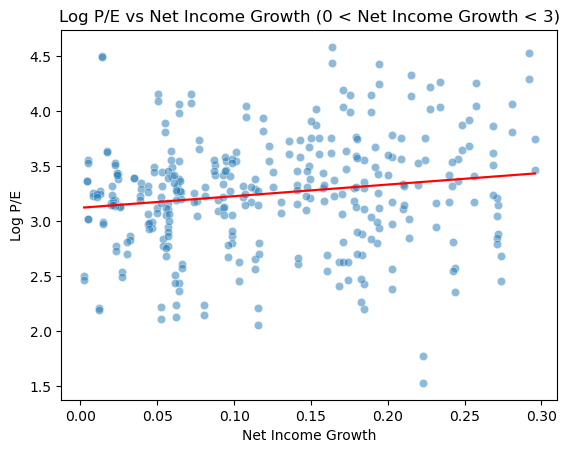

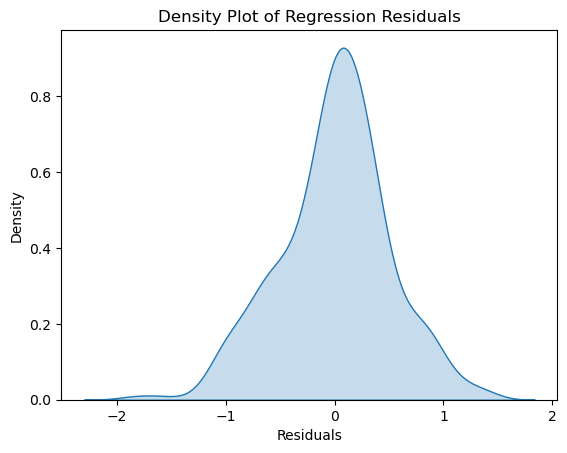

In [11]:
# Scatter + regression line
sns.scatterplot(x='netIncome_yoy', y='log_pe', alpha= 0.5, data=reg_data)
sns.lineplot(x=reg_data['netIncome_yoy'], y=model.predict(X), color='red')
plt.xlabel('Net Income Growth')
plt.ylabel('Log P/E')
plt.title('Log P/E vs Net Income Growth (0 < Net Income Growth < 3)')
plt.show()

# Density plot of residuals
sns.kdeplot(model.resid, fill=True)
plt.xlabel('Residuals')
plt.title('Density Plot of Regression Residuals')
plt.show()


/var/folders/3v/cffbrkr510z708th2gtn8s600000gn/T/ipykernel_6394/3489120168.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data_rev['revenue_yoy'] = pd.to_numeric(reg_data_rev['revenue_yoy'], errors='coerce')
/var/folders/3v/cffbrkr510z708th2gtn8s600000gn/T/ipykernel_6394/3489120168.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data_rev['log_pe'] = pd.to_numeric(reg_data_rev['log_pe'], errors='coerce')


                            OLS Regression Results                            
Dep. Variable:                 log_pe   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     5.262
Date:                Tue, 26 Aug 2025   Prob (F-statistic):             0.0227
Time:                        11:39:38   Log-Likelihood:                -333.69
No. Observations:                 239   AIC:                             671.4
Df Residuals:                     237   BIC:                             678.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.2395      0.197     16.482      

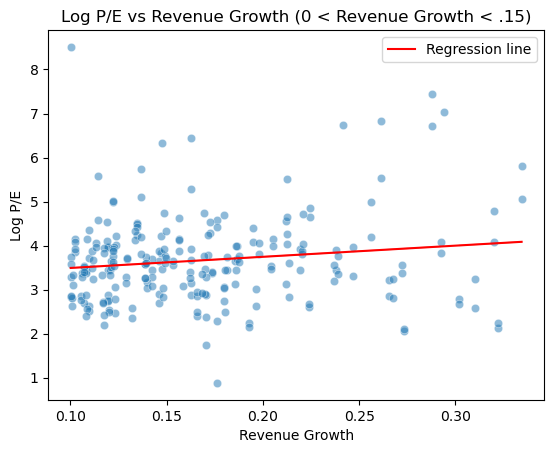

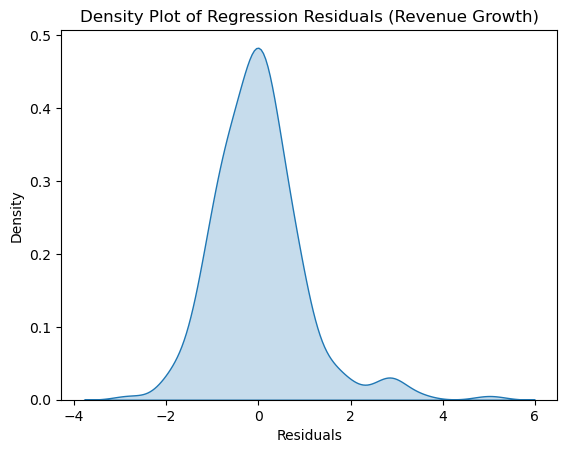

In [16]:
# Merge the log P/E column with the net income YoY growth
reg_data = pd.merge(
    income_data_yoy[['symbol', 'log_pe']],        # log P/E from income_data_yoy
    income_growth_clean[['symbol', 'revenue_yoy']],  # YoY growth from income_growth_clean
    on='symbol',                                  # merge on the 'symbol' column
    how='inner'                                   # keep only symbols present in both
)

# Optional: filter netIncome_yoy between 0 and 3
reg_data = reg_data[(reg_data['revenue_yoy'] > 0) & (reg_data['revenue_yoy'] < 3)]


# Keep only positive revenue_yoy and finite log_pe
reg_data_rev = reg_data[(reg_data['revenue_yoy'] > 0) & 
                        (reg_data['revenue_yoy'] < .15) &
                        (reg_data['log_pe'].notna()) & 
                        np.isfinite(reg_data['log_pe'])]

# Convert to numeric if needed
reg_data_rev['revenue_yoy'] = pd.to_numeric(reg_data_rev['revenue_yoy'], errors='coerce')
reg_data_rev['log_pe'] = pd.to_numeric(reg_data_rev['log_pe'], errors='coerce')

# Drop any rows that couldn't convert
reg_data_rev = reg_data_rev.dropna(subset=['revenue_yoy','log_pe'])

# Define dependent and independent variables
y_rev = reg_data_rev['log_pe']           # dependent
X_rev = sm.add_constant(reg_data_rev['revenue_yoy'])    # independent with constant

# Fit OLS regression
model_rev = sm.OLS(y_rev, X_rev).fit()

# Regression summary
print(model_rev.summary())

# Scatter + regression line
sns.scatterplot(x='revenue_yoy', y='log_pe', data=reg_data_rev, alpha=0.5)
sns.lineplot(x=reg_data_rev['revenue_yoy'], y=model_rev.predict(X_rev), color='red', label='Regression line')
plt.xlabel('Revenue Growth')
plt.ylabel('Log P/E')
plt.title('Log P/E vs Revenue Growth (0 < Revenue Growth < .15)')
plt.legend()
plt.show()

# Density plot of residuals
sns.kdeplot(model_rev.resid, fill=True)
plt.xlabel('Residuals')
plt.title('Density Plot of Regression Residuals (Revenue Growth)')
plt.show()
